In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import matplotlib.pyplot as plt
from models.model4 import FourWheelModel


import time

In [11]:
import matplotlib.pyplot as plt

def plot_column_histograms(data):
    """
    Plots a histogram for each column of a 2D numpy array.
    """
    num_cols = data.shape[1]  # Get the number of columns in the data
    
    # Plot a histogram for each column
    for i in range(num_cols):
        plt.hist(data[:, i], bins=10)  # Plot the histogram
        
        # Set the plot title and axis labels
        plt.title(f"Histogram of Column {i}")
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        
        plt.show()  # Show the plot

def plot_histogram_1dnparray(data):
    # Plot the histogram
    plt.hist(data, bins=30, edgecolor='black')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Data')
    plt.grid(True)

    # Show the plot
    plt.show()

In [4]:
# Define a four wheel model
dt = 0.05
open_loop_tf = 1000

T_peak = 0.37
T_slope = 0.4

model4 = FourWheelModel(dt, open_loop_tf, T_peak, T_slope)


kappa = 1
steering = 0.2
total_steering = kappa*steering


radius_kinematic = model4.kinematik_model_radius(total_steering)
print('Theoretical radius for kinematic model', radius_kinematic)


Theoretical radius for kinematic model 7.585623609657709


Text(0, 0.5, 'Radius')

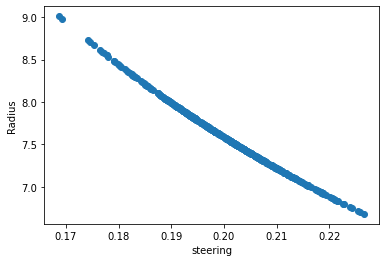

In [15]:
# sample kapp from a distribtution and create data
np.random.seed(2023)
steering = 0.2
data_size = 500
# set parameters
steering = np.full(data_size,0.2)

for i in range(len(steering)):
    steering[i] += np.random.normal(0,0.01)

sigma = 1

# obtain response and add noise
steering_from_kappa_samle = np.zeros(data_size)
for i in range(len(steering)):
    steering_from_kappa_samle[i] = model4.kinematik_model_radius(steering[i])
steering_from_kappa_samle.reshape(-1,1)

#Plot data
# plot data 
plt.scatter(steering, steering_from_kappa_samle)
plt.xlabel("steering")
plt.ylabel("Radius")

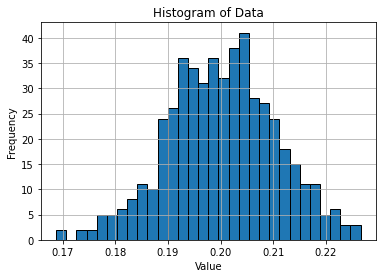

In [16]:
plot_histogram_1dnparray(steering)


In [7]:
def proposal(prec_theta, search_width = 0.5):
    # this function generates the proposal for the new theta
    # we assume that the distribution of the random variables 
    # is normal for the first two and gamma for the third.
    # conditional on the previous value of the accepted parameters (prec_theta)
    out_theta = np.zeros(2)
    out_theta[0] = sc.multivariate_normal(mean=prec_theta[:1],cov=np.eye(1)*search_width**2).rvs(1)
    #the last component is the noise
    out_theta[1] = sc.gamma(a=prec_theta[1]*search_width*500, scale=1/(500*search_width)).rvs()
    return out_theta

def lhd(y, theta):
    # x is the data matrix, first column for input and second column for output.
    # theta is a vector containing the parameters for the evaluation
    # remember theta[0] is a, theta[1] is b and theta[2] is sigma
    start_time1 = time.time()
    proposed_radius = model4.kinematik_model_radius(theta[0])
    mean = np.full(y.shape[0], proposed_radius).reshape(-1,1)
    #print(mean.shape)
    #print(mean.dtype)
    end_time1 = time.time()
    lhd_out = sc.norm.logpdf(y, loc= mean, scale=theta[1])
    end_time2 = time.time()

    #print("np.full",end_time1-start_time1)
    #print("lhdout",end_time2-end_time1)
    
    # then we sum lhd_out (be careful here, we are summing instead of multiplying
    # because we are dealing with the log-likelihood, instead of the raw likelihood).
    lhd_out = np.sum(lhd_out)
    return lhd_out

def prior(theta):
    # evaluate the prior for the parameters on a multivariate gaussian. 
    prior_out = sc.multivariate_normal.logpdf(theta[:1],mean=np.array([0]), cov=np.eye(1)*100)
    # this needs to be summed to the prior for the sigma, since I assumed independence.
    prior_out += sc.gamma.logpdf(theta[1], a=1, scale=1)
    return prior_out

def proposal_ratio(theta_old, theta_new, search_width=10):
    # this is the proposal distribution ratio
    # first, we calculate of the pdf of the proposal distribution at the old value of theta with respect to the new 
    # value of theta. And then we do the exact opposite.
    walk = 1
    prop_ratio_out = sc.multivariate_normal.logpdf(theta_old[:1],mean=theta_new[:1], cov=np.eye(1)*search_width**2)
    prop_ratio_out += sc.gamma.logpdf(theta_old[1], a=theta_new[1]*walk*500, scale=1/(500*walk))
    prop_ratio_out -= sc.multivariate_normal.logpdf(theta_new[:1],mean=theta_old[:1], cov=np.eye(1)*search_width**2)
    prop_ratio_out -= sc.gamma.logpdf(theta_new[1], a=theta_old[1]*walk*500, scale=1/(500*walk))
    return prop_ratio_out

In [13]:
np.random.seed(2023)
width = 0.2

thetas = np.random.rand(2).reshape(1,-1)
accepted = 0
rejected = 0

N = 10000

for i in range(N):

    # 1) provide a proposal for theta
    theta_new = proposal(thetas[-1,:], search_width=width)
    
    # 2) calculate the likelihood of this proposal and the likelihood
    # for the old value of theta
    
    log_lik_theta_new = lhd(steering_from_kappa_samle, theta_new)
    
    log_lik_theta = lhd(steering_from_kappa_samle, thetas[-1,:])
    
    
    # 3) evaluate the prior log-pdf at the current and at the old value of theta
    theta_new_prior = prior(theta_new)
    theta_prior = prior(thetas[-1,:])

    
    # 4) finally, we need the proposal distribution ratio
    prop_ratio = proposal_ratio(thetas[-1], theta_new, search_width=width)
    
    # 5) assemble likelihood, priors and proposal distributions
    likelihood_prior_proposal_ratio = log_lik_theta_new - log_lik_theta + \
                             theta_new_prior - theta_prior + prop_ratio
    
    # 6) throw a - possibly infinitely weigthed - coin. The move for Metropolis-Hastings is
    # not deterministic. Here, we exponentiate the likelihood_prior_proposal ratio in order
    # to obtain the probability in linear scale
    if (np.exp(likelihood_prior_proposal_ratio)) > sc.uniform().rvs():
        thetas = np.vstack((thetas,theta_new))
        accepted += 1
    else:
        rejected += 1

    
    
    if i%500 == 0:
        print(f"Iteration number {i}")

Iteration number 0


/var/folders/mw/9cttllqs2yv0dqrlc62m0l8h0000gn/T/ipykernel_52604/1255594952.py:38: RuntimeWarning: overflow encountered in exp
  if (np.exp(likelihood_prior_proposal_ratio)) > sc.uniform().rvs():


Iteration number 500
Iteration number 1000
Iteration number 1500
Iteration number 2000
Iteration number 2500
Iteration number 3000
Iteration number 3500
Iteration number 4000
Iteration number 4500
Iteration number 5000
Iteration number 5500
Iteration number 6000
Iteration number 6500
Iteration number 7000
Iteration number 7500
Iteration number 8000
Iteration number 8500
Iteration number 9000
Iteration number 9500


(0.19959729079405134, 0.005841346806282768)


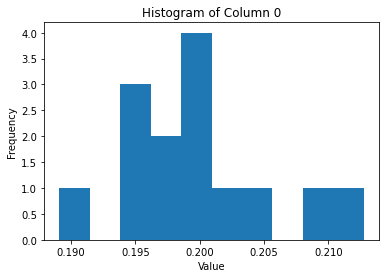

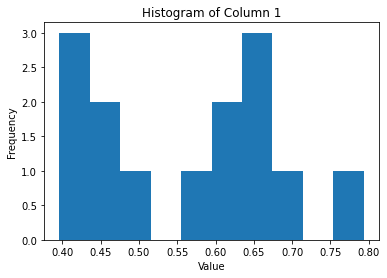

In [20]:
burn_in = int(thetas.shape[0]*0.2)
thetas_burned = thetas[burn_in:, :]
thetas_burned.shape
res = sc.norm.fit(thetas_burned[:,0])
print(res)
plot_column_histograms(thetas_burned)